## Punctate metric is biasing genes with fewer spots per cell to have more punctate scores

Same issue with radial metric

Definitely occuring when the number of spots, m = 1

Not sure actually if this is occuring when m > 1, but I'll test that now

I've added a method to the Cell class to filter out genes with counts below a threshold

In [1]:
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import SRRS
from SRRS import scoring, metrics, plotting

importlib.reload(SRRS)
importlib.reload(metrics)
importlib.reload(scoring)
importlib.reload(plotting)

sample = SRRS.HDF5('../inputs/m1s1_subset.hdf5')
sample.num_cells

KeyboardInterrupt: 

In [ ]:
%%time
#fast
unfilt_cells = [c for c in sample.iter_cells() if c.n > 300]
unfilt_scored_cells = list(scoring._iter_scores(unfilt_cells, metric_name='radial', processes=3))

len(unfilt_scored_cells)

In [ ]:
%%time

#slow since gene_vars need to be recalculated
min_gene_spots = 2
filt_cells = [c.filter_low_count_genes(min_gene_spots) for c in sample.iter_cells() if c.n > 300]

filt_cells = scoring._iter_vars(filt_cells)    
filt_scored_cells = list(scoring._iter_scores(filt_cells, metric_name='radial', processes=3))

len(filt_scored_cells)

In [ ]:
#get median gene ranks for each cell
pd.concat(scoring.iter_scores(filt_scored_cells, metric='radial'))

In [ ]:
#get per spot per cell ranks instead
data = {
    'filtering':[],
    'cell_id':[],
    'gene':[],
    'rank':[],
    'm':[],
    'n':[],
}

for filtering,cells in (('filt',filt_scored_cells),('unfilt',unfilt_scored_cells)):
    for cell in cells:
        for z in cell.zslices:
            for g,r in zip(cell.spot_genes[z], cell.spot_ranks[z]):
                data['filtering'].append(filtering)
                data['cell_id'].append(cell.cell_id)
                data['gene'].append(g)
                data['rank'].append(r)
                data['m'].append(cell.gene_counts[g])
                data['n'].append(cell.n)
            
spot_ranks = pd.DataFrame(data)
spot_ranks  

In [ ]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('unfilt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Unfiltered, Single count-genes (m=0) have biased ranks')
plt.show()
plt.close()

In [ ]:
plot_df = spot_ranks[
    spot_ranks['filtering'].eq('filt') &
    spot_ranks['cell_id'].eq('98094925393968329130254909503130262661')
].copy()
plot_df['Single count'] = plot_df['m'].eq(1)

ax = sns.scatterplot(
    x = 'm',
    y = 'rank',
    alpha = 0.1,
    hue = 'Single count',
    data = plot_df,
)
ax.set_title('Filtered no-single count-genes are un-biased(?)')
plt.show()
plt.close()

# Formalizing test for punctate bias by gene-count

Now that I've applied the filtering, I can visually see that the bias might be removed

But how can I quantitatively be sure?

I'm going to start by plotting punctate score vs gene/fraction from all cells and see if it "looks correct"

In [ ]:
score_df = pd.concat(scoring.iter_scores(filt_scored_cells, metric='radial'),ignore_index=True)
score_df

In [ ]:
score_df['Gene fraction'] = score_df['num_gene_spots'].div(score_df['num_spots'])
max_frac = score_df['Gene fraction'].quantile(0.8)

p = sns.jointplot(
    x = 'Gene fraction',
    y = 'score',
    kind = 'hex',
    color = 'grey',
    data = score_df[score_df['Gene fraction'].le(max_frac)],
)

p.ax_joint.axhline(0,linestyle='dotted',color='blue')
p.ax_marg_y.axhline(0,linestyle='dotted',color='blue')

#p.ax_joint.set_xlim(0,max_frac)

p.fig.suptitle('Radial score vs. gene-fraction in individual cells')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room #got code from https://stackoverflow.com/questions/60358228/how-to-set-title-on-seaborn-jointplot

plt.show()
plt.close()

the plot does "look" correct, but maybe I can visualize in a different way by binning the gene fractions and plotting CDFs

In [ ]:
sns.histplot(score_df['Gene fraction'])
plt.show()
plt.close()

In [ ]:
bins = np.arange(0,0.1,0.01)

score_df['Gene fraction bin'] = pd.cut(score_df['Gene fraction'], bins=bins)
ax = sns.ecdfplot(
    x = 'score',
    hue = 'Gene fraction bin',
    palette = 'Reds',
    data = score_df,
)
ax.axhline(0.5, linestyle='dashed', color='black')
ax.axvline(0.0, linestyle='dashed', color='black')
plt.xlabel('Radial score')
plt.show()
plt.close()

# "Choose two" bootstrapping punctate metric

In [ ]:
import importlib
import SRRS
from SRRS import metrics, plotting, scoring, simulate

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sample = SRRS.HDF5('../inputs/filtered_out_one_gene_counts/mouse1sample1.hdf5')
sample

In [ ]:
iter_cells = sample.iter_cells()
cell = next(iter_cells)
cell = next(iter_cells)
cell = next(iter_cells)
cell = next(iter_cells)
cell = next(iter_cells)
cell = next(iter_cells)
cell = next(iter_cells)

fig,ax = plotting.plot_cell_3D(cell)
plt.show()
plt.close()

In [ ]:
len(cell.genes)

In [ ]:
importlib.reload(metrics)

In [ ]:
%%time
cell.ranked = False
df = metrics.punctate(cell, num_iterations=1000)
df

In [ ]:
# testing if there is bias in the "choose 2" approach by permuting gene labels
df = pd.Series(dtype='float64')
df.index.name = 'gene'

for i in range(1000):
    if i%10 == 0:
        print(i)
        
    cell = simulate.null_permute_gene_labels(cell, within_z=False)
    scores = metrics.punctate(cell, num_iterations=100)
    
    df = pd.concat((df,scores))
    
df = df.reset_index(name='score')
df

In [ ]:
df.shape

In [ ]:
df['spot_count'] = df['gene'].map(cell.gene_counts)

sns.ecdfplot(
    x = 'score',
    hue = 'spot_count',
    data = df,
)
plt.axhline(0.5,linestyle='dashed',color='grey')
plt.axvline(0.0,linestyle='dashed',color='grey')
plt.show()
plt.close()

In [ ]:
df['spot_count'] = df['gene'].map(cell.gene_counts)

sns.ecdfplot(
    x = 'score',
    hue = 'gene',
    data = df,
)
plt.axhline(0.5,linestyle='dashed',color='grey')
plt.axvline(0.0,linestyle='dashed',color='grey')
plt.show()
plt.close()

## Searching for bug in "pick-two" code that could be leading to bias on null

In [ ]:
import random
import numpy as np
import collections

In [ ]:
cell.gene_counts

In [ ]:
len(cell.genes)

In [ ]:
gene_ranks_df

In [ ]:
gene_dists

In [ ]:
num_iterations = 1000

spot_gene_coords = [
    (g,(x,y)) for z in cell.zslices
    for g,(x,y) in zip(cell.spot_genes[z],cell.spot_coords[z])
]

gene_ranks = {g:[] for g in cell.genes}

for i in range(num_iterations):
    #shuffle the spot order
    random.shuffle(spot_gene_coords)

    #choose two spots from each gene to be representatives (NOTE can do this more efficiently!)
    g_reps = {g:[] for g in cell.genes}
    for gene,xy in spot_gene_coords:
        if len(g_reps[gene]) < 2:
            g_reps[gene].append(xy)

    #measure x,y euclidean distance between two spots (NOTE ignoring z)
    gene_dists = []
    for gene in g_reps:
        x1,y1 = g_reps[gene][0]
        x2,y2 = g_reps[gene][1]
        dist = (x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)
        gene_dists.append((dist,gene))
    
    #rank by sorting and store results
    for i,(d,g) in enumerate(sorted(gene_dists)):
        gene_ranks[g].append(i+1)
        
#Calculate the per-gene score
exp_med_rank = (len(cell.genes)+1)/2
obs_med_ranks = [np.mean(gene_ranks[gene]) for gene in cell.genes]
gene_scores = map(lambda o: (exp_rank-o)/(exp_rank-1), obs_med_ranks)

score_df = pd.DataFrame({
    'gene':cell.genes,
    'obs_med_rank':obs_med_ranks,
    'score':gene_scores
})

score_df

In [ ]:
exp_rank

In [ ]:
score_df['score'].mean()

In [ ]:
np.array(dists)

In [ ]:
np.array(dists).argsort()

In [ ]:
np.array(dists).argsort().argsort()+1

In [ ]:
dists

In [ ]:
spot_usage = pd.DataFrame(all_rep_spots, columns=['gene','x','y']).groupby(['gene','x','y']).size().reset_index(name='count')
spot_usage

In [ ]:
gene_order = spot_usage['gene'].value_counts().index

fig = plt.figure(figsize=(4,10))
sns.barplot(
    x = 'count',
    y = 'gene',
    color = 'grey',
    order = gene_order,
    data = spot_usage,
)
plt.title('Gene spots are chosen with equal chance per cell')
plt.xlabel('Number of times a spot is chosen')
plt.show()
plt.close()

In [ ]:
spot_gene_coords

In [ ]:
plotting.plot_cell_zslices?

In [ ]:
importlib.reload(plotting)

In [ ]:
num_genes = len(cell.genes)
cs = sns.color_palette('viridis',num_genes)
gcs = {g:c for g,c in zip(cell.genes,cs)}

fig,ax = plotting.plot_cell_zslices(cell, gene_colors=gcs)
plt.show()
plt.close()

## "Pick two" punctate score filtering to have different numbers of genes/counts

In [ ]:
import importlib
import copy

import SRRS
from SRRS import metrics, plotting, scoring, simulate

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importlib.reload(SRRS)
importlib.reload(metrics)

sample = SRRS.HDF5('../inputs/filtered_out_one_gene_counts/mouse1sample1.hdf5')

iter_cells = sample.iter_cells()
cell = next(iter_cells)
#cell = next(iter_cells)
#cell = next(iter_cells)
#cell = next(iter_cells)
#cell = next(iter_cells)
#cell = next(iter_cells)
#cell = next(iter_cells)

orig_cell = copy.deepcopy(cell)

fig,ax = plotting.plot_cell_3D(cell)
plt.show()
plt.close()

In [ ]:
len(sample.cells())

In [ ]:
%%time
importlib.reload(simulate)

simulate.gene_cell_sim_null_peripheral(
    cells = sample.cells(),
    metric = 'peripheral',
    within_z = False,
    n_its = 20,
    processes = 1,
)

In [ ]:
#remove all genes which don't have 3 spots (occurs in place)
#cell.filter_genes_by_count(min_gene_spots=3, max_gene_spots=3)

In [ ]:
cell.gene_counts

In [ ]:
%%time
importlib.reload(metrics)
scores = metrics.punctate(cell, num_iterations=1000, num_pairs=4)

In [ ]:
%%time
#create null background of cells to test for biases
# testing if there is bias in the approach by permuting gene labels on this filtered cell
df = pd.DataFrame()

num_cells = 1000
num_label_swaps = 100
num_choose_two_perms = 4

df = pd.DataFrame()

for i in range(num_cells):
    if i%10 == 0:
        print(i)
        
    cell = simulate.null_permute_gene_labels(cell, within_z=False)
    scores = metrics.punctate(cell, num_iterations=num_label_swaps, num_pairs=num_choose_two_perms)
        
    df = pd.concat((df,scores))
    
df

In [ ]:
#I'm expecting to see more variance for genes with fewer counts
#The variances seem low, but I don't know why I say that
#The values can only be between -1 and 1
sns.scatterplot(
    x = 'spot_count',
    y = 'var',
    color = 'grey',
    data = df,
)
plt.show()
plt.close()

In [ ]:
#On this simulated dataset, expect each spot-count to have the same distribution of scores
sns.boxplot(
    x = 'spot_count',
    y = 'score',
    color = 'white',
    data = df,
)
sns.stripplot(
    x = 'spot_count',
    y = 'score',
    color = 'black',
    alpha = 0.05,
    data = df.sample(10000),
)
plt.title('Punctate score on population of 1000 null cells does not have bias by spot-count')
plt.show()
plt.close()

In [ ]:
sns.ecdfplot(
    x = 'score',
    hue = 'spot_count',
    data = df[df['spot_count'].isin([2,52])].reset_index(),
)
plt.axhline(0.5, linestyle='dashed', color='grey')
plt.axvline(0, linestyle='dashed', color='grey')
plt.show()
plt.close()

In [ ]:
g = sns.jointplot(
    x = 'spot_count',
    y = 'score',
    kind = 'hex',
    color = 'black',
    data = df.reset_index(drop=True),
)

g.ax_joint.axhline(0,linestyle='dashed',color='grey')
g.ax_marg_y.axhline(0,linestyle='dashed',color='grey')

plt.show()
plt.close()

In [ ]:
df.head()

# Output from permutation-based punctate scores on real data

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('../punctate_refactored_mouse1sample1.csv')
df.head()

In [ ]:
print(df['cell_id'].nunique(),'cells')
print(df['gene'].nunique(),'genes')

In [ ]:
df['num_gene_spots'].nunique()

In [ ]:
sns.displot(
    x = 'score',
    data = df,
)
plt.show()
plt.close()

In [ ]:
df[df['score'].eq(1)]

In [ ]:
sns.jointplot(
    x = 'num_gene_spots',
    y = 'score',
    color = 'black',
    alpha = 0.05,
    data = df,
)
plt.show()
plt.close()

In [ ]:
sns.ecdfplot(
    x = 'num_gene_spots',
    label = 'All scores',
    data = df[df['num_gene_spots'].le(100)],
)
sns.ecdfplot(
    x = 'num_gene_spots',
    label = 'Scores of 1',
    data = df[df['num_gene_spots'].le(100) & df['score'].eq(1)],
)
sns.ecdfplot(
    x = 'num_gene_spots',
    label = 'Scores of -1',
    data = df[df['num_gene_spots'].le(100) & df['score'].eq(-1)],
)
plt.legend()
plt.title('Gene/cells with scores of 1 have fewer gene spots')
plt.show()
plt.close()

In [ ]:
sns.ecdfplot(
    x = 'score',
    label = 'Any number of spots',
    data = df,
)

sns.ecdfplot(
    x = 'score',
    label = 'One spot',
    data = df[df['num_gene_spots'].eq(2)],
)

plt.axhline(0.5, linestyle='dashed', color='grey')
plt.axvline(0.0, linestyle='dashed', color='grey')
plt.legend()
plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(15,2))
sns.boxplot(
    x = 'num_gene_spots',
    y = 'score',
    color = 'white',
    data = df[df['num_spots'].le(150)],
)
plt.axhline(0.0, linestyle='dashed', color='grey')
plt.title('Median scores are above 0 for most spot-counts')
plt.show()
plt.close()

In [ ]:
#visualizing some of the extreme gene/cell scores
import SRRS
from SRRS import plotting

sample = SRRS.HDF5('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/mouse1sample1.hdf5')
sample

### all these gene/cells have a score of 1 (very punctate

In [ ]:
cell = sample.get_cells_by_id(['222098490380092065288492113826920653088'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Aqp4':'red'})
plt.show()
plt.close()

In [ ]:
cell = sample.get_cells_by_id(['86160538687897987056485308143342788364'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Col25a1':'red'})
plt.show()
plt.close()

In [ ]:
cell = sample.get_cells_by_id(['227833902103094513653469756064354589296'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Satb2':'red'})
plt.show()
plt.close()

In [ ]:
cell = sample.get_cells_by_id(['5920985237459637946126883927110494777'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Reln':'red'})
plt.show()
plt.close()

### all of these gene/cells have a score of -1

In [ ]:
df[df['score'].eq(1) & df['num_gene_spots'].eq(10)]

In [ ]:
cell = sample.get_cells_by_id(['176207460594798926125106281154597702567'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Col24a1':'red'})
plt.show()
plt.close()

In [ ]:
cell = sample.get_cells_by_id(['222098490380092065288492113826920653088'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Ramp1':'red'})
plt.show()
plt.close()

In [ ]:
cell = sample.get_cells_by_id(['20412369700126259876450951845622773712'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Sulf2':'red'})
plt.show()
plt.close()

In [ ]:
cell = sample.get_cells_by_id(['120119137789607729623614875913849203969'])[0]
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Trp53i11':'red'})
plt.show()
plt.close()

## Output from permutation-based punctate score on permuted data (not real!)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('../null_permute_punctate_refactored_mouse1sample2.csv')
df.head()

In [ ]:
sns.jointplot(
    x = 'num_gene_spots',
    y = 'score',
    color = 'black',
    alpha = 0.05,
    data = df,
)
plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(15,2))
sns.boxplot(
    x = 'num_gene_spots',
    y = 'score',
    color = 'white',
    data = df[df['num_spots'].le(100)],
)
sns.stripplot(
    x = 'num_gene_spots',
    y = 'score',
    color = 'black',
    alpha = 0.1,
    data = df[df['num_spots'].le(100)],
)
plt.axhline(0.0, linestyle='dashed', color='grey')
plt.title('Median scores are above 0 for most spot-counts')
plt.show()
plt.close()

# Radial metric using bootstrapping

In [ ]:
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import SRRS
from SRRS import scoring, metrics, plotting

In [ ]:
sample = SRRS.HDF5('../inputs/m1s1_subset.hdf5')
cell = sample.cells()[2]

In [ ]:
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Egln3':'red'})
ax.elev = 90
plt.show()
plt.close()

In [ ]:
subcells = sample.cells()[:30]
len(subcells)

In [ ]:
%%time
#took 110 seconds for 30 cells without parallel setup
#took 98 seconds for 30 cells with parallel setup but only 1 process (overhead cost check) (surprised it's faster?)
#took 51 seconds for 30 cells with parallel setup with 2 process
#took 35 seconds for 30 cells with parallel setup with 3 process
#took 28 seconds for 30 cells with parallel setup with 4 process

x = scoring.iter_scores(subcells, metric='radial', num_iterations=1000, processes=4)
x.sort_values('score')

In [ ]:
%%time
#took 7.7 seconds for a single cell
x = scoring.iter_scores([cell],metric='radial',num_iterations=1000)
x.sort_values('score')

In [ ]:
#score is very positive, should be highly "radially clustered"
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Nos1':'red'})
ax.elev = 90
plt.show()
plt.close()

In [ ]:
#score is very positive, should be highly "radially clustered"
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Tshz2':'red'})
ax.elev = 90
plt.show()
plt.close()

In [ ]:
#score is very positive, should be highly "radially clustered"
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Elfn1':'red'})
ax.elev = 90
plt.show()
plt.close()

In [ ]:
#score is very negative, should be highly "radially diffuse"
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Unc5d':'red'})
ax.elev = 90
plt.show()
plt.close()

In [ ]:
#score is very negative, should be highly "radially diffuse"
fig,ax = plotting.plot_cell_3D(cell, gene_colors={'Adra1b':'red'})
ax.elev = 90
plt.show()
plt.close()

# Checking the radial output of one sample for biases

This is on real data, I'll rerun for permuted data

There does look to be biases where genes with fewer numbers of counts have more punctate scores

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
radial_df = pd.read_csv('../mouse1sample1_radial_scores.csv')
radial_df.head()

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance
0,radial,10032793791539981569759397028350596090,L23_IT_1,112,Slc30a3,31,-0.704,3.487241e-07
1,radial,10032793791539981569759397028350596090,L23_IT_1,112,Dscaml1,2,-0.016,3.512970e-06
2,radial,10032793791539981569759397028350596090,L23_IT_1,112,Wipf3,11,0.546,4.394805e-07
3,radial,10032793791539981569759397028350596090,L23_IT_1,112,Camk2d,5,0.672,7.046990e-07
4,radial,10032793791539981569759397028350596090,L23_IT_1,112,Cux2,10,0.328,4.221602e-07


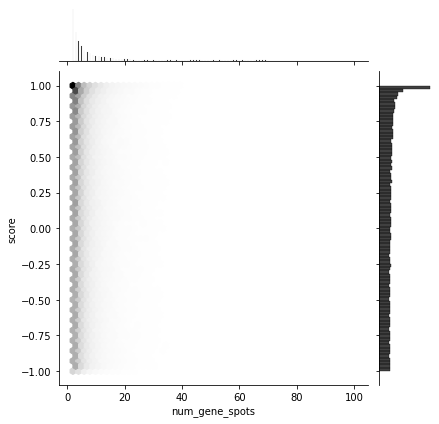

In [8]:
sns.jointplot(
    x = 'num_gene_spots',
    y = 'score',
    kind = 'hex',
    #scatter_kws = {'alpha':0.1},
    color = 'black',
    data = radial_df[radial_df['num_gene_spots'].le(100)],
)
plt.show()
plt.close()

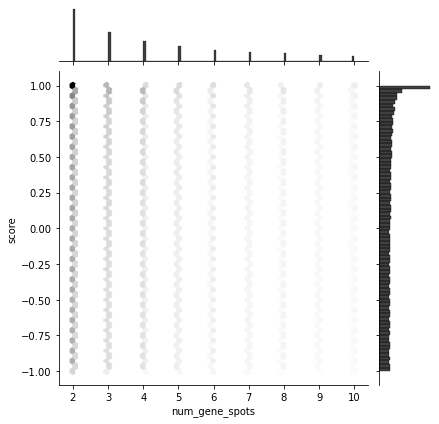

In [9]:
sns.jointplot(
    x = 'num_gene_spots',
    y = 'score',
    kind = 'hex',
    #scatter_kws = {'alpha':0.1},
    color = 'black',
    data = radial_df[radial_df['num_gene_spots'].le(10)],
)
plt.show()
plt.close()

# Checking radial for biases in permuted gene labels

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
radial_df = pd.read_csv('../mouse1sample1_radial_permuted_scores.csv')
radial_df.head()

In [ ]:
sns.jointplot(
    x = 'num_gene_spots',
    y = 'score',
    kind = 'hex',
    #scatter_kws = {'alpha':0.1},
    color = 'black',
    data = radial_df[radial_df['num_gene_spots'].le(100)],
)
plt.show()
plt.close()

In [ ]:
sns.jointplot(
    x = 'num_gene_spots',
    y = 'score',
    kind = 'hex',
    #scatter_kws = {'alpha':0.1},
    color = 'black',
    data = radial_df[radial_df['num_gene_spots'].le(10)],
)
plt.show()
plt.close()